In [7]:
import numpy as np
import pandas as pd

# plotting + metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ML bits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier  # Snippet A
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

In [8]:
#Create path
path = r'/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Prepared Data'

In [9]:
# -------------------------------
# 1) Load two datasets
# -------------------------------
# X = weather observations (already scaled)
weather_df = pd.read_pickle(os.path.join(path, 'weather_scaled.pkl'))
# y = pleasant/unpleasant answers
answers_df = pd.read_csv(os.path.join(path, 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))

In [16]:
# -------------------------------
# 2) Align by DATE, then drop metadata
# -------------------------------
# Keep DATE just long enough to align rows between X and y
if "DATE" not in weather_df.columns:
    raise ValueError("Expected a DATE column in weather_scaled.pkl")

if "DATE" not in answers_df.columns:
    raise ValueError("Expected a DATE column in the answers CSV")

# Inner-merge to keep only dates present in BOTH files
merged = weather_df.merge(answers_df, on="DATE", how="inner", suffixes=("_X", "_y"))

# Recover X and y parts from merged:
# - X columns are those that originally came from weather_df
# - y columns are the ones from answers_df (excluding DATE)
x_cols = [c for c in weather_df.columns]
y_cols = [c for c in answers_df.columns if c != "DATE"]

X_all = merged[x_cols].copy()
y_all = merged[y_cols].copy()

In [17]:
# -------------------------------
# 3) Drop stations with insufficient labels
# -------------------------------
stations_to_drop = ["GDANKS", "ROMA", "TOURS"]

# Drop in X: anything starting with those station names + underscore
def drop_station_prefixes(df, stations):
    cols_to_drop = []
    for s in stations:
        cols_to_drop += [c for c in df.columns if c.startswith(s + "_")]
        # in case any columns are named exactly the station (rare)
        if s in df.columns:
            cols_to_drop.append(s)
    return df.drop(columns=list(set(cols_to_drop)), errors="ignore")

X_all = drop_station_prefixes(X_all, stations_to_drop)

# Drop in y: columns like GDANKS_pleasant_weather etc.
y_all = drop_station_prefixes(y_all, stations_to_drop)


In [18]:

# -------------------------------
# 4) Drop DATE/MONTH (already not in X_all/y_all anymore after merge)
#     but keep this guard for safety if present
# -------------------------------
X_all = X_all.drop(columns=["DATE", "MONTH"], errors="ignore")
y_all = y_all.drop(columns=["DATE"], errors="ignore")

# Sanity check: same number of rows
assert len(X_all) == len(y_all), "Row mismatch after alignment"


In [19]:

# -------------------------------
# 5) Train/test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)



=== k = 1 ===
train_acc=1.0000 | test_acc=0.4266

=== k = 2 ===
train_acc=0.5609 | test_acc=0.4449

=== k = 3 ===
train_acc=0.5699 | test_acc=0.4551

=== k = 4 ===
train_acc=0.5203 | test_acc=0.4582


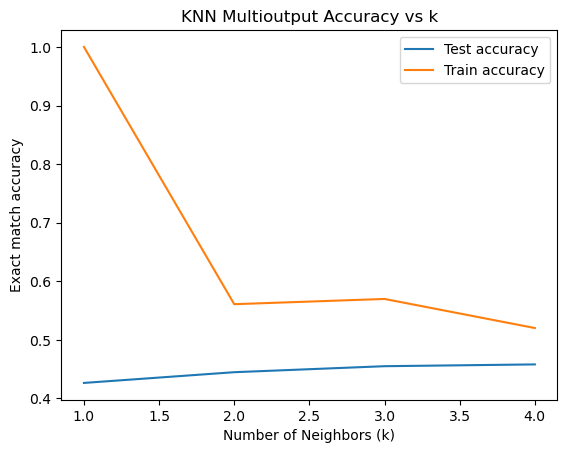


Best k by test accuracy: 4


In [20]:
# -------------------------------
# 6) KNN (multilabel) with small k_range
#    (This is Snippet B, corrected to use the classifier wrapper)
# -------------------------------
k_range = np.arange(1, 5)  # 1..4 inclusive
train_acc = np.empty(len(k_range))
test_acc = np.empty(len(k_range))

best_idx = None
best_micro = -1.0
all_preds_by_k = {}  # keep predictions for later plots if needed

for i, k in enumerate(k_range):
    print(f"\n=== k = {k} ===")
    knn = KNeighborsClassifier(n_neighbors=k)
    classifier = MultiOutputClassifier(knn, n_jobs=-1)  # ADD THIS LINE

    # Fit/predict with the wrapper (multilabel)
    classifier.fit(X_train, y_train)                    # CHANGE to classifier.fit
    y_pred = classifier.predict(X_test)                 # CHANGE to classifier.predict

    train_acc[i] = classifier.score(X_train, y_train)   # CHANGE to classifier.score
    test_acc[i]  = classifier.score(X_test,  y_test)    # CHANGE to classifier.score
    print(f"train_acc={train_acc[i]:.4f} | test_acc={test_acc[i]:.4f}")

    all_preds_by_k[k] = y_pred

# Plot train/test accuracy vs k
plt.figure()
plt.plot(k_range, test_acc, label='Test accuracy')
plt.plot(k_range, train_acc, label='Train accuracy')
plt.legend()
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Exact match accuracy')
plt.title('KNN Multioutput Accuracy vs k')
plt.show()

# Pick the best k by test accuracy (you could also use micro-F1, etc.)
best_k = int(k_range[np.argmax(test_acc)])
print(f"\nBest k by test accuracy: {best_k}")
best_pred = all_preds_by_k[best_k]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


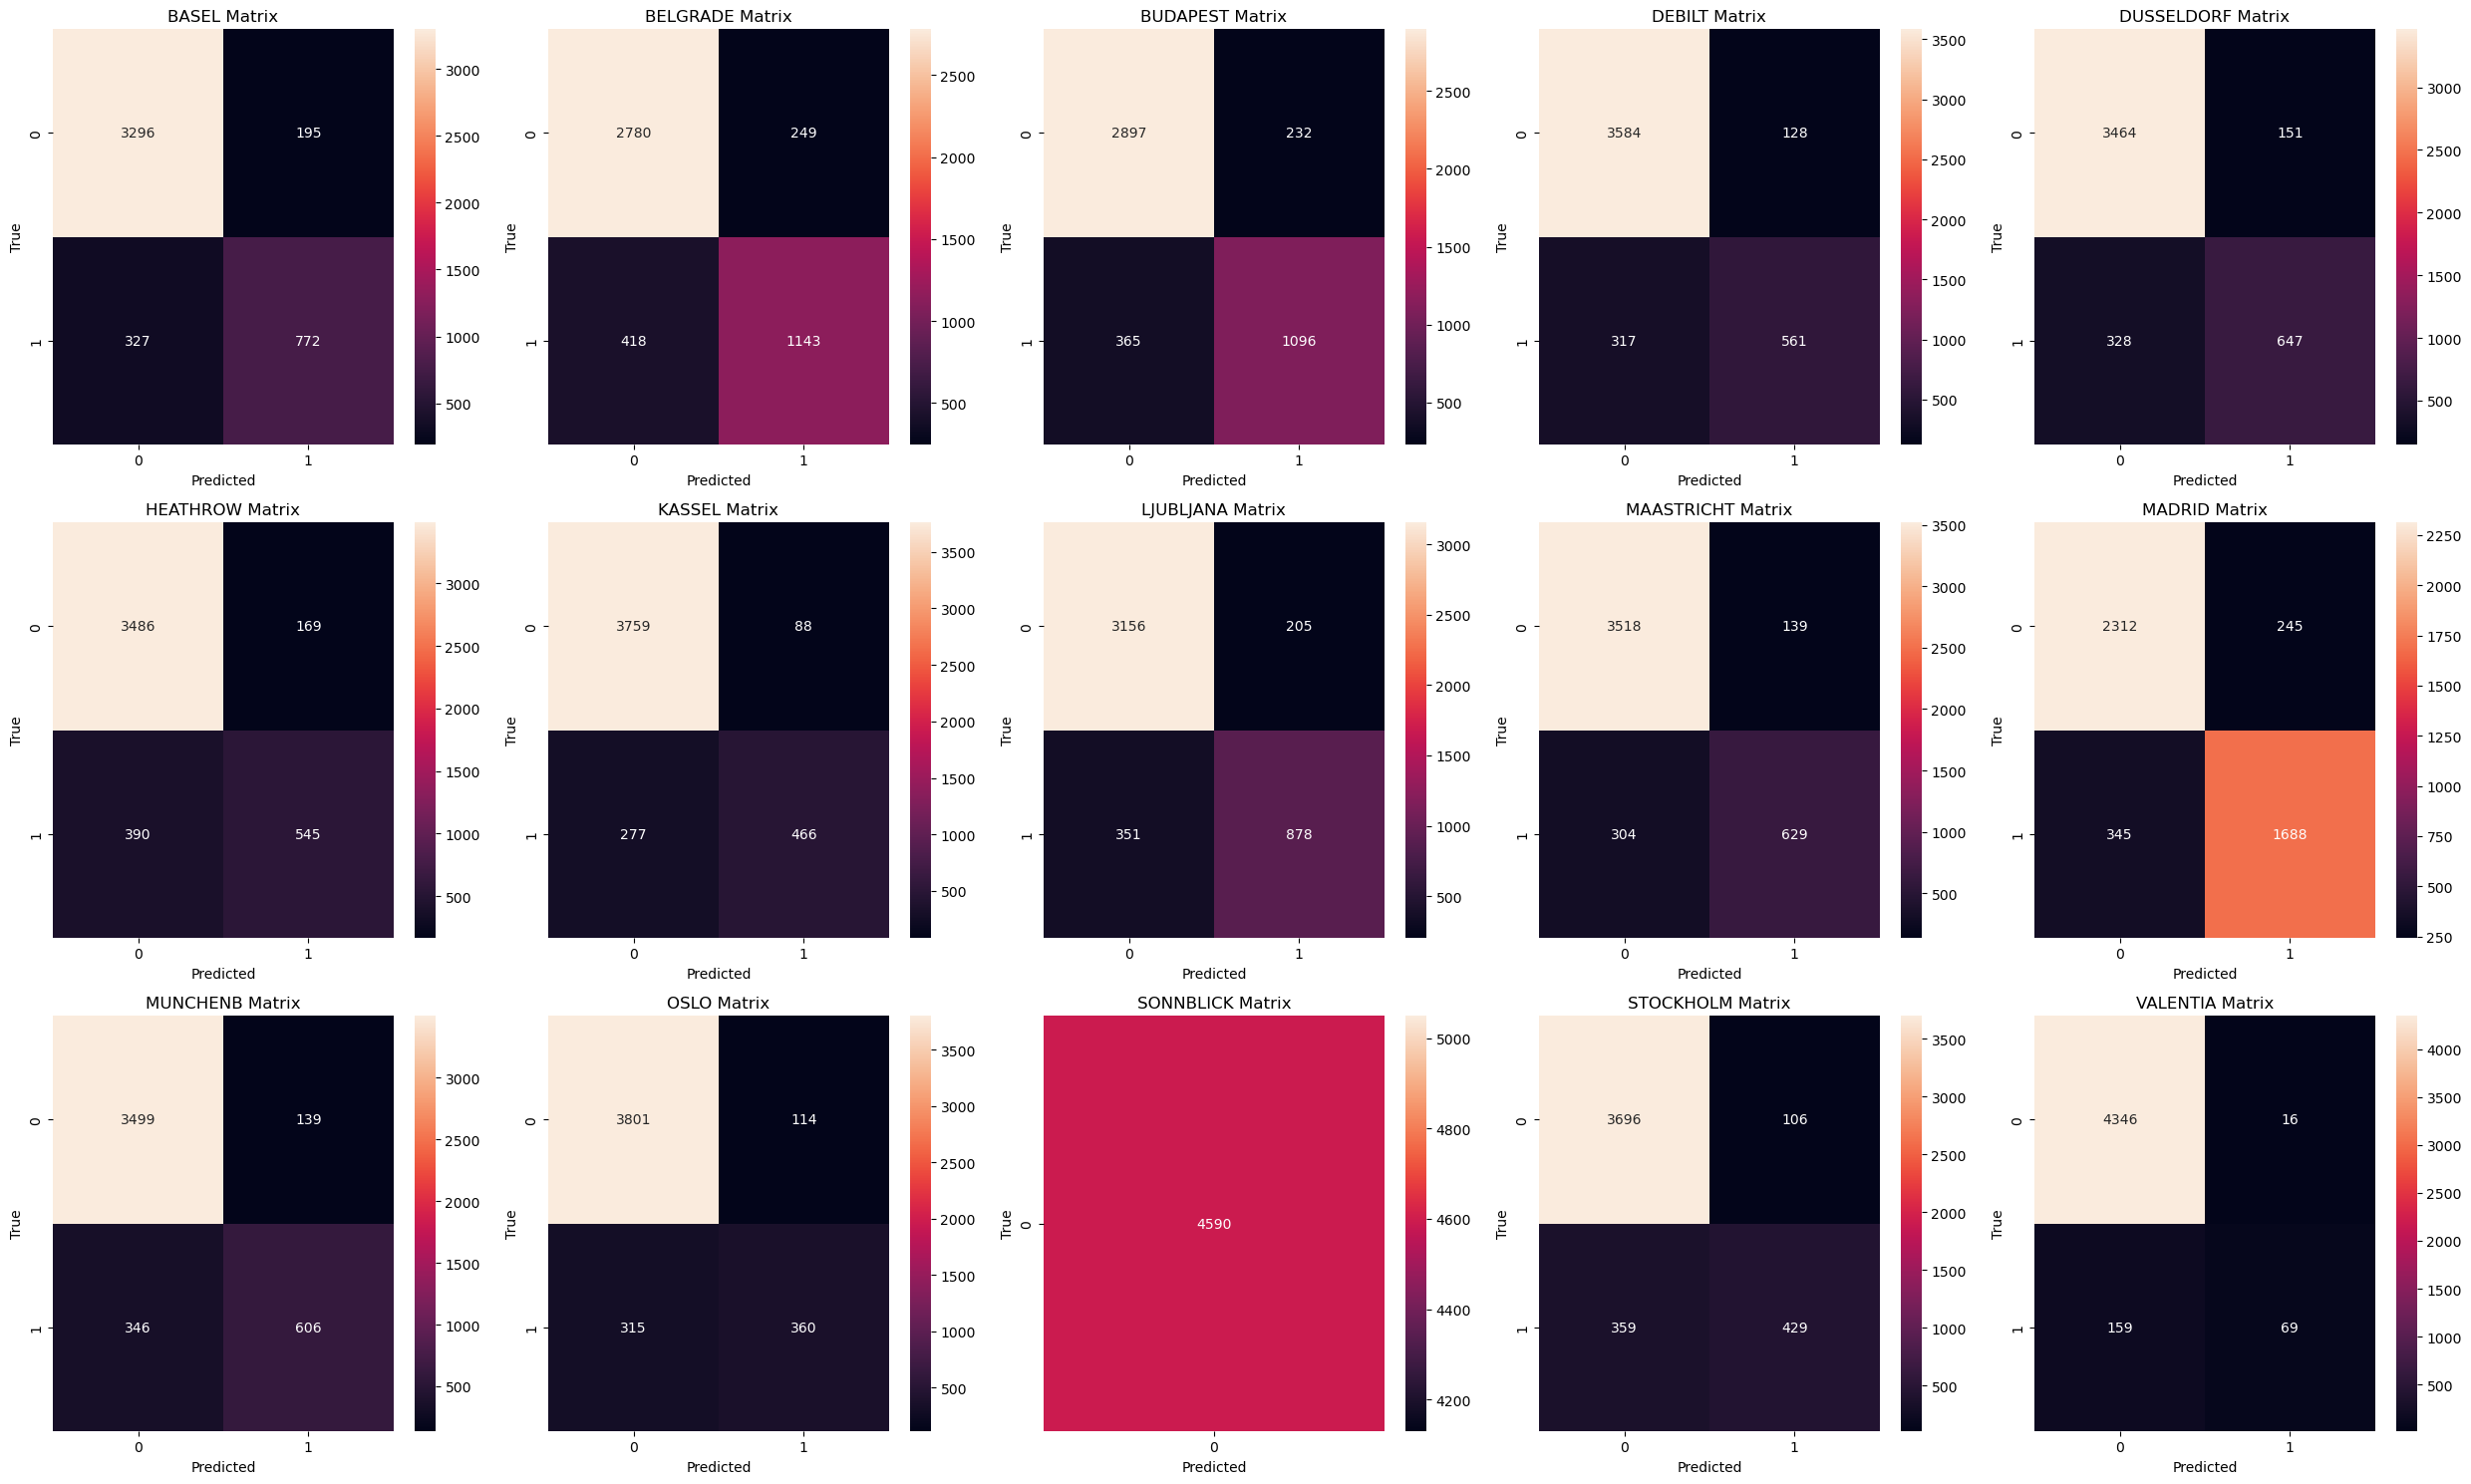

In [21]:

# -------------------------------
# 7) Multilabel confusion matrices (Snippet C)
#     We need a station list. Build from X feature names.
#     Your answer columns are usually like STATION + "_pleasant_weather"
# -------------------------------
df = X_all  # used only to derive station names
locations = list({c.split("_")[0] for c in df.columns if c not in ["MONTH", "DATE"]})
locations.sort()

key = "_pleasant_weather"
# Ensure we only plot stations that exist in y columns
stations = [s for s in locations if (s + key) in y_all.columns]

rows, cols = 3, 5  # 15 panes as per directions
fig, ax = plt.subplots(rows, cols, figsize=(25, 15))
count = 0
for i in range(rows):
    for j in range(cols):
        if count >= len(stations):
            ax[i, j].axis('off')
            continue

        name = stations[count]
        colname = name + key

        # y_test is a DataFrame; best_pred is a numpy array aligned with y_test columns order.
        # We need the correct column index for this station in y_test:
        if colname not in y_test.columns:
            ax[i, j].axis('off')
            count += 1
            continue

        label_idx = list(y_test.columns).index(colname)
        cm = confusion_matrix(y_test.iloc[:, label_idx], best_pred[:, label_idx])

        sns.heatmap(cm, annot=True, fmt='g', ax=ax[i, j])
        ax[i, j].set_xlabel('Predicted')
        ax[i, j].set_ylabel('True')
        ax[i, j].set_title(f'{name} Matrix')
        count += 1

plt.tight_layout()
plt.show()


In [22]:
# -------------------------------
# 8) Record results
# -------------------------------
print("\nFinal summary:")
for i, k in enumerate(k_range):
    print(f"k={k}: train_acc={train_acc[i]:.4f}, test_acc={test_acc[i]:.4f}")
print(f"\nBest k: {best_k}")


Final summary:
k=1: train_acc=1.0000, test_acc=0.4266
k=2: train_acc=0.5609, test_acc=0.4449
k=3: train_acc=0.5699, test_acc=0.4551
k=4: train_acc=0.5203, test_acc=0.4582

Best k: 4
